# `4_numexpr.ipynb`

This notebook focuses on accelerating the stencil computations presented in the [lists and NumPy notebook](./1_lists_numpy.ipynb) using [NumExpr](https://github.com/pydata/numexpr).

In [1]:
import os
import math
import numpy as np
os.environ['NUMEXPR_MAX_THREADS'] = '24'
os.environ['NUMEXPR_NUM_THREADS'] = '12'
import numexpr as ne
import numba
from IPython.display import Markdown as md

In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

NumExpr focuses on accelerating elementwise operations on NumPy arrays. Let's say, for example, that we have two arrays `a` and `b`, and we want to compute `0.5*sin(a)**2 + 0.5*cos(b)**2`. There are two extremes to do this.

## Introduction

### The NumPy way

In [4]:
def numpy_test(a, b):
    return 0.5 * np.sin(a)**2 + 0.5 * np.cos(b)**2

In [5]:
%%timeit -o a = initialize_field(NX, NY, NZ); b = initialize_field(NX, NY, NZ)
c = numpy_test(a, b)

40 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 40 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [6]:
result_numpy_test = _

### The Python way

In [7]:
def python_test(a, b):
    c = np.empty_like(a)
    for k in range(NZ):
        for j in range(NY):
            for i in range(NX):
                c[k, j, i] = 0.5 * math.sin(a[k, j, i])**2 + 0.5 * math.cos(b[k, j, i])**2
    return c

In [8]:
%%timeit -o a = initialize_field(NX, NY, NZ); b = initialize_field(NX, NY, NZ)
c = python_test(a, b)

1.02 s ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.02 s ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [9]:
result_python_test = _

The two approaches are completely opposite. The problem with the NumPy way is that is uses temporary arrays as large as `a` and `b` to do the calculation, which may be a problem if these arrays are huge. Memory-wise this approach is not very efficient and it is also not ideal for a good use of cache memory. For example, the results of `0.5 * sin(a)**2` and `0.5 * cos(b)**2` will not be in cache when they need to be added to obtain the final result.

On the other hand, the python approach is very slow because of the large overhead due to the `for` loops. In [the Numba notebook](./2_numba.ipynb) we have seen how to overcome this by compiling certain parts of the code on runtime. In this notebook we will see how to do something similar with NumExpr.

### The NumExpr way

In [10]:
def numexpr_aggressive_test(a, b):
    return ne.evaluate("0.5 * sin(a)**2 + 0.5 * cos(b)**2", optimization="aggressive")

def numexpr_moderate_test(a, b):
    return ne.evaluate("0.5 * sin(a)**2 + 0.5 * cos(b)**2", optimization="moderate")

The principal routine of NumExpr is `evaluate()`. At least, we should pass a string forming a valid expression. NumExpr will translate the `str` to the actual arrays using `sys._getframe()`, although it is also possible to explicitly pass a `local_dict` or a `global_dict` to the function, mapping the strings used in the expression with the desired Python variables.

Finally, there is the kwarg `optimization`, which can take the values `"moderate"` or `"aggressive"` (default). The difference between these two modes is that in the former the expression will not be rewritten in a way that precision could be affected, while in the later some changes (e.g. `x**3` -> `x*x*`) are done to achieve better performance. In any case, the precision differences should be always small no matter what optimization mode we choose.

NumExpr aims to achieve better performance than NumPy by avoiding allocating memory for intermediate results. Additionally, although it will not be tested in this project, it can take advantage of the Intel MKL library.

### Benchmark time

In [11]:
# No benchmark, let's run once just so that NumExpr can optimize/compile the code
a = initialize_field(NX, NY, NZ)
b = initialize_field(NX, NY, NZ)
c1 = numexpr_aggressive_test(a, b)
c2 = numexpr_moderate_test(a, b)

In [12]:
%%timeit -o a = initialize_field(NX, NY, NZ); b = initialize_field(NX, NY, NZ)
c = numexpr_aggressive_test(a, b)

3.7 ms ± 56.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.7 ms ± 56.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [13]:
result_numexpr_test_aggressive = _

In [14]:
%%timeit -o a = initialize_field(NX, NY, NZ); b = initialize_field(NX, NY, NZ)
c = numexpr_moderate_test(a, b)

3.72 ms ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.72 ms ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [15]:
result_numexpr_test_moderate = _

In [16]:
best_numexpr = min(result_numexpr_test_aggressive.average, result_numexpr_test_moderate.average)
numexpr_vs_numpy = compare_results(best_numexpr, result_numpy_test.average, "faster")
numexpr_vs_python = compare_results(best_numexpr, result_python_test.average, "faster")

md(f"""
With this quick test we observe that code accelerated with NumExpr is **{numexpr_vs_numpy} faster
than the NumPy code**, and **{numexpr_vs_python} faster than the Python code** with loops.
""")


With this quick test we observe that code accelerated with NumExpr is **~11 faster
than the NumPy code**, and **~276 faster than the Python code** with loops.


Let's check the same test with Numba to have a quick first comparison between these two packages.

In [17]:
@numba.jit(nopython=True, parallel=True)
def numba_test(a, b):
    c = np.empty_like(a)
    for k in numba.prange(NZ):
        for j in range(NY):
            for i in range(NX):
                c[k, j, i] = 0.5 * math.sin(a[k, j, i])**2 + 0.5 * math.cos(b[k, j, i])**2
    return c

In [18]:
# Let Numba compile before benchmarking
a = initialize_field(NX, NY, NZ)
b = initialize_field(NX, NY, NZ)
c = numba_test(a, b)

In [19]:
%%timeit -o a = initialize_field(NX, NY, NZ); b = initialize_field(NX, NY, NZ)
c = numba_test(a, b)

3.51 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.51 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [20]:
result_numba_test = _

NumExpr and Numba achieve a very similar performance gain. This makes NumExpr a good candidate to accelerate code that does elementwise operations. However, as we will see later, NumExpr is not ideal to work with the most general stencil computations.

## Pointwise stencil

### $a(i) = b(i)$

In [21]:
def numexpr_pointwise(in_field):
    for n in range(N_ITER):
        out_field = ne.evaluate("in_field")
    return out_field

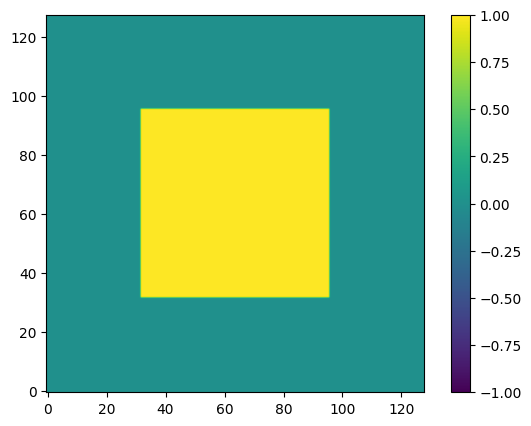

In [22]:
# first call to optimize/compile
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = numexpr_pointwise(in_field)
plot_field(out_field)

In [23]:
%%timeit -o in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_pointwise(in_field)

11.4 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 11.4 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [24]:
result_numexpr_pointwise = _
save_result(result_numexpr_pointwise, "numexpr_pointwise")

In [25]:
time_list_pointwise = read_results("list_pointwise")
time_numpy_pointwise = read_results("numpy_pointwise")
time_numba_parallel_pointwise = read_results("numba_parallel_pointwise")

md(f"""
| Function                     |  Time                                           |
|:-----------------------------|------------------------------------------------:|
| `list_pointwise()`           |  {time_list_pointwise}s                         |
| `numpy_pointwise()`          |  {time_numpy_pointwise * 1e6:.1f}μs             |
| `numba_parallel_pointwise()` |  {time_numba_parallel_pointwise * 1e3:.1f}ms    |
| `numexpr_pointwise()`        |  {result_numexpr_pointwise.average * 1e3:.1f}ms |
""")


| Function                     |  Time                                           |
|:-----------------------------|------------------------------------------------:|
| `list_pointwise()`           |  8.22s                         |
| `numpy_pointwise()`          |  35.7μs             |
| `numba_parallel_pointwise()` |  3.3ms    |
| `numexpr_pointwise()`        |  11.4ms |


In [26]:
numexpr_vs_numba = compare_results(time_numba_parallel_pointwise, result_numexpr_pointwise.average, "faster")

md(f"""
NumExpr code for the copy stencil is slower than Numba. In particular, Numba code using `@njit(parallel=True)`
is **{numexpr_vs_numba} times faster than NumExpr**.
""")


NumExpr code for the copy stencil is slower than Numba. In particular, Numba code using `@njit(parallel=True)`
is **~3.4 times faster than NumExpr**.


### $a(i) = \sin(b(i))$

In [27]:
def numexpr_sin_pointwise(in_field):
    for n in range(N_ITER):
        out_field = ne.evaluate("sin(in_field)")
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

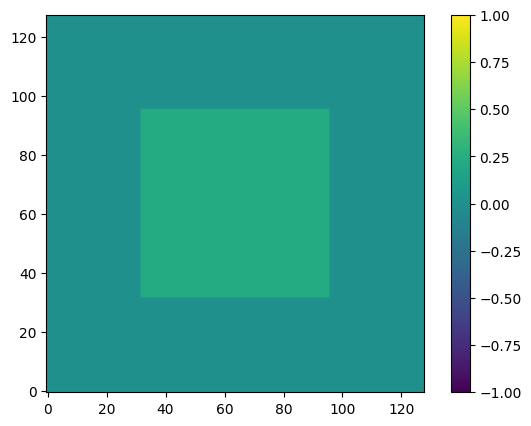

In [28]:
# first call to optimize/compile
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = numexpr_sin_pointwise(in_field)
plot_field(out_field)

In [29]:
%%timeit -o in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_sin_pointwise(in_field)

86.1 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 86.1 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [30]:
result_numexpr_sin_pointwise = _
save_result(result_numexpr_sin_pointwise, "numexpr_sin_pointwise")

In [31]:
time_numpy_sin_pointwise = read_results("numpy_sin_pointwise")
time_numba_sin_pointwise = read_results("numba_parallel_sin_pointwise")
numexpr_vs_numpy = compare_results(result_numexpr_pointwise.average, time_numpy_sin_pointwise, "faster")
numexpr_vs_numba = compare_results(time_numba_sin_pointwise, result_numexpr_sin_pointwise.average, "faster")

md(f"""
The pointwise `sin()` stencil accelerated with **NumExpr is {numexpr_vs_numpy} times faster than using NumPy vectorized code**.
But, once again, **Numba is {numexpr_vs_numba} times faster than NumExpr**.
""")


The pointwise `sin()` stencil accelerated with **NumExpr is ~76 times faster than using NumPy vectorized code**.
But, once again, **Numba is ~1.4 times faster than NumExpr**.


In [32]:
md(f"""
| Function                    |  Time                                               |
|:----------------------------|----------------------------------------------------:|
| `numpy_sin_pointwise()`     |  {time_numpy_sin_pointwise * 1e3:.0f}ms             |
| `numba_sin_pointwise()`     |  {time_numba_sin_pointwise * 1e3:.1f}ms             |
| `numexpr_sin_pointwise()`   |  {result_numexpr_sin_pointwise.average * 1e3:.1f}ms |
""")


| Function                    |  Time                                               |
|:----------------------------|----------------------------------------------------:|
| `numpy_sin_pointwise()`     |  868ms             |
| `numba_sin_pointwise()`     |  61.6ms             |
| `numexpr_sin_pointwise()`   |  86.1ms |


We could conclude already that there seems to be no reason to prefer NumExpr over Numba. Accelerating code with Numba is easier (we just need to wrap a function with a decorator) and way more flexible since we can accelerate any computation and not just pointwise calculations. For very especific (and complex) calculations, NumExpr could potentially lead to better performance gains, but with these two stencils we have observed that Numba code is faster than NumExpr.

## 1D stencils

The remaining stencils cannot be done with NumExpr directly. But we will try to use NumPy views to achieve the same results. The idea is to have just one base array, and create multiple shifted views assigned to different variables, so that we can pass this to the `evaluate()` routine. In the case of the 1D stencils, we only need two views. The 2D will be more challenging.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [33]:
def numexpr_1D_same_col(in_field):
    out_field = np.empty_like(in_field)
    for n in range(N_ITER):
        # Views of arrays to pass to NumExpr
        a = in_field[:, :, 1:]
        b = in_field[:, :, :-1]
        # Line accelerated with NumExpr
        out_field[:, :, :-1] = ne.evaluate("0.5 * a - 0.5 * b")
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

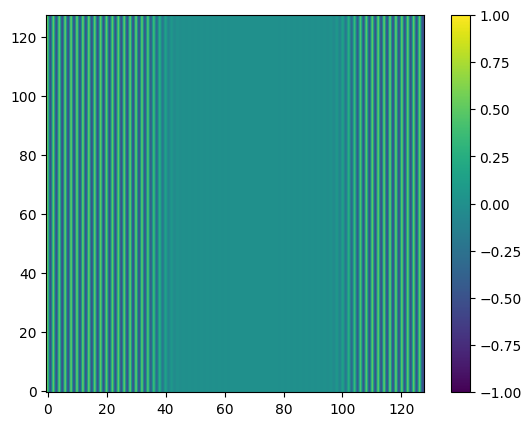

In [34]:
in_field = initialize_field(NX, NY, NZ, mode="vertical-bars")
out_field = numexpr_1D_same_col(in_field)
plot_field(out_field)

Using the same pattern of vertical bars as in previous notebooks, we can see that the result is correct. This means that the trick of using NumPy views to trick NumExpr to do calculations involving different gridpoints works. Let's check if we can observe any performance gain, or if this trick cancels the benefits of NumExpr.

In [35]:
%%timeit -o in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_1D_same_col(in_field)

96.8 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 96.8 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [36]:
result_numexpr_1D_same_col = _
save_result(result_numexpr_1D_same_col, "numexpr_1D_same_col")

In [37]:
time_numpy_1D_same_col = read_results("numpy_1D_same_col")
time_numba_1D_same_col = read_results("numba_1D_same_col")

md(f"""
| Function                |  Time                                             |
|:------------------------|--------------------------------------------------:|
| `numpy_1D_same_col()`   |  {time_numpy_1D_same_col * 1e3:.0f}ms             |
| `numba_1D_same_col()`   |  {time_numba_1D_same_col * 1e3:.1f}ms             |
| `numexpr_1D_same_col()` |  {result_numexpr_1D_same_col.average * 1e3:.0f}ms |
""")


| Function                |  Time                                             |
|:------------------------|--------------------------------------------------:|
| `numpy_1D_same_col()`   |  117ms             |
| `numba_1D_same_col()`   |  3.7ms             |
| `numexpr_1D_same_col()` |  97ms |


In [38]:
numexpr_vs_numpy = compare_results(result_numexpr_1D_same_col.average, time_numpy_1D_same_col, "faster-%")
numexpr_vs_numba = compare_results(time_numba_1D_same_col, result_numexpr_1D_same_col.average, "faster")

md(f"""
NumExpr code is **only {numexpr_vs_numpy} faster** than vectorized NumPy code.
And Numba is almost one order of magnitude faster, **Numba is {numexpr_vs_numba} times faster than NumExpr**.
""")


NumExpr code is **only ~21% faster** than vectorized NumPy code.
And Numba is almost one order of magnitude faster, **Numba is ~26 times faster than NumExpr**.


Based on these results, we don't expect NumExpr to produce any significant performance increase with respect to Numba in the case of the 2D stencil.
Instead, we will explore the following open questions:

- What is the impact of using Fortran-style arrays instead of C-style?
- Can NumExpr be interesting for other (larger) fields?

## NumExpr with Fortran-style arrays

Let's fix all the dimensions to the same value, and let's run the benchmark of the sine pointwise stencil with both C-style and Fortran-style arrays.

In [39]:
NZ = NY = NX = 128

In [40]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, array_order="C")
out_field = numexpr_sin_pointwise(in_field)

136 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 136 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [41]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, array_order="F")
out_field = numexpr_sin_pointwise(in_field)

133 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 133 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

Contrary to what we observed with Numba, there seems to be little or no difference wheter we use row-major o col-major arrays.

## NumExpr vs Numba for larger fields

We have seen that Numba seems to be faster than NumExpr, but we have only tested for a fix size. Let's rerun the pointwise sine stencil for difference sizes.

In [42]:
@numba.jit(nopython=True, parallel=True)
def numba_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        for k in numba.prange(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

in_field = initialize_field(NX, NY, NZ)
out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)

In [43]:
NZ = NY = NX = 200

In [44]:
%%timeit in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_sin_pointwise(in_field)

699 ms ± 9.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)

92 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
NZ = NY = NX = 300

In [47]:
%%timeit in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_sin_pointwise(in_field)

2.28 s ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)

94.7 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
NZ = NY = NX = 400

In [50]:
%%timeit in_field = initialize_field(NX, NY, NZ)
out_field = numexpr_sin_pointwise(in_field)

5.34 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = numba_parallel_sin_pointwise(in_field, out_field)

96 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


There doesn't seem to be a size at which NumExpr could perform better than Numba.

### NumExpr 1D vs 3D arrays

The last thing we will test is whether the shape of the arrays can impact the performance of NumExpr. In the documentation they always show examples with 1D arrays, so let's check if we can measure any difference.

In [52]:
NZ = NY = NX = 200
size_array = 200**3

rng = np.random.default_rng(1337)

In [53]:
%%timeit in_field = rng.random(size=(NZ, NY, NX))
out_field = numexpr_sin_pointwise(in_field)

617 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit in_field = rng.random(size_array)
out_field = numexpr_sin_pointwise(in_field)

617 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There is no difference between having a multidimensional array and a single dimension array.